In this project, the XGBoost Regression technique will be applied to predict house prices, based on the famous Kaggle Dataset https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

In [2]:
#=========================================================================
# load up the libraries
#=========================================================================
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from operator import itemgetter
from datetime import date
from xgboost import plot_importance
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import GridSearchCV
import shap

#=========================================================================
# Loading in the dataset
#=========================================================================
train_data = pd.read_csv('train.csv',index_col=0)
test_data  = pd.read_csv('test.csv',index_col=0)

### <center>Feature Exploration and Selection </center>. 

In [3]:
#===========================================================================
# Viewing the data properties
#===========================================================================

train_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
#===========================================================================
# Formatting the train and test dataset, introducing proper naming conventions
#===========================================================================

X_train = train_data.select_dtypes(include=['number'])
X_train = X_train.drop(['SalePrice'], axis=1)
y_train = train_data['SalePrice']
X_test  = test_data.select_dtypes(include=['number'])

X_train.shape, y_train.shape

((1460, 36), (1460,))

In [5]:
#===========================================================================
# Summary descriptive statistics
#===========================================================================

X_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


In [6]:
#===========================================================================
# Checking for null values in the training data
#===========================================================================

for col_name, nulls in X_train.isnull().sum().items():
    if nulls != 0:
        print(f'{col_name} has {nulls} missing values')

LotFrontage has 259 missing values
MasVnrArea has 8 missing values
GarageYrBlt has 81 missing values


In [7]:
#===========================================================================
# Checking for null values in the testing data
#===========================================================================

for col_name, nulls in X_test.isnull().sum().items():
    if nulls != 0:
        print(f'{col_name} has {nulls} missing values')

LotFrontage has 227 missing values
MasVnrArea has 15 missing values
BsmtFinSF1 has 1 missing values
BsmtFinSF2 has 1 missing values
BsmtUnfSF has 1 missing values
TotalBsmtSF has 1 missing values
BsmtFullBath has 2 missing values
BsmtHalfBath has 2 missing values
GarageYrBlt has 78 missing values
GarageCars has 1 missing values
GarageArea has 1 missing values


In [8]:
#===========================================================================
# Filling null values with the mean.
#===========================================================================

X_train = X_train.fillna(X_train.mean())
X_test  = X_test.fillna(X_test.mean())

In [9]:
#===========================================================================
# Setting up the Random Forest Regressor to perform Recursive Feature Elimination, RFE
#===========================================================================

rfr = RandomForestRegressor(n_estimators=100, max_depth=10)

n_features = 1
rfe = RFE(rfr, n_features_to_select=n_features)
rfe.fit(X_train, y_train)

#===========================================================================
# Printing the ranked features obtained from RFE
#===========================================================================

features = X_train.columns.to_list()
for x, y in (sorted(zip(rfe.ranking_, features), key=itemgetter(0))):
    print(x, y)

1 OverallQual
2 GrLivArea
3 TotalBsmtSF
4 BsmtFinSF1
5 2ndFlrSF
6 YearBuilt
7 1stFlrSF
8 GarageArea
9 GarageCars
10 LotArea
11 YearRemodAdd
12 LotFrontage
13 MasVnrArea
14 BsmtUnfSF
15 TotRmsAbvGrd
16 OpenPorchSF
17 OverallCond
18 FullBath
19 WoodDeckSF
20 GarageYrBlt
21 Fireplaces
22 MoSold
23 MSSubClass
24 BedroomAbvGr
25 ScreenPorch
26 YrSold
27 BsmtFullBath
28 HalfBath
29 KitchenAbvGr
30 EnclosedPorch
31 BsmtFinSF2
32 BsmtHalfBath
33 PoolArea
34 3SsnPorch
35 LowQualFinSF
36 MiscVal


### <center>Feature engineering</center>

In [10]:
#===========================================================================
# Creating new features, number of bathrooms and total area with basement
#===========================================================================

for df in (X_train, X_test):
    df["n_bathrooms"] = df["BsmtFullBath"] + (df["BsmtHalfBath"]*0.5) + df["FullBath"] + (df["HalfBath"]*0.5)
    df["area_with_basement"]  = df["GrLivArea"] + df["TotalBsmtSF"]

In [11]:
#===========================================================================
# Creating a new column, which is the age of the house
#===========================================================================

for df in (X_train, X_test):
    df["HouseAge"] = date.today().year - pd.to_datetime(X_train["YearBuilt"], format='%Y').dt.year

### <center>GridSearchCV and XGBoost estimator</center>

In [12]:
#=========================================================================
# XGBoost regression: 
# Parameters: 
# n_estimators  "Number of gradient boosted trees. Equivalent to number 
#                of boosting rounds."
# learning_rate "Boosting learning rate (also known as “eta”)"
# max_depth     "Maximum depth of a tree. Increasing this value will make 
#                the model more complex and more likely to overfit." 
#=========================================================================
regressor=xgb.XGBRegressor(eval_metric='rmsle')

#=========================================================================
# exhaustively searching for the optimal hyperparameters
#=========================================================================

# setting up the search grid

param_grid = {"max_depth":    [4, 5, 6, 7, 8, 10],
              "n_estimators": [500, 600, 700, 800],
              "learning_rate": [0.01, 0.015, 0.2, 0.25, 0.5, 0.75, 0.8]}

In [13]:
#===========================================================================
# Calling the function with base model and hyperparameters
#===========================================================================

search = GridSearchCV(estimator=regressor, 
                           param_grid=param_grid, 
                           n_jobs=-1, verbose=1)

search.fit(X_train, y_train);

Fitting 5 folds for each of 168 candidates, totalling 840 fits


In [14]:
print("The best hyperparameters are ", search.best_params_)

The best hyperparameters are  {'learning_rate': 0.25, 'max_depth': 4, 'n_estimators': 600}


#### <center>Fitting of optimal hyperparameters to XGBoost model</center>

In [15]:
#===========================================================================
# Model with optimal hyperparamters is fitted to training dataset
#===========================================================================

regressor = xgb.XGBRegressor(n_estimators=600, eval_metric='rmsle', max_depth=4, learning_rate=0.25, random_state=42)

# fit the model to the training set
regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmsle', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.25, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=600, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [16]:
#===========================================================================
# Final tuned model is used to predict testing data
#===========================================================================

predictions = regressor.predict(X_test)

In [17]:
#===========================================================================
# Testing model predictions 
#===========================================================================

solution   = pd.read_csv('train.csv')
solution.drop(solution.index[1459:1460], axis=0, inplace=True)
y_true     = solution["SalePrice"]

RMSLE = np.sqrt( mean_squared_log_error(y_true, predictions))
print("The score is %.5f" % RMSLE )

The score is 0.55479


### <center>Final submission for evaluation</center>

In [18]:
output = pd.DataFrame({"Id":test_data.index, "SalePrice":predictions})
output.to_csv('submission.csv', index=False)

### <center>Some feature importance analysis</center>

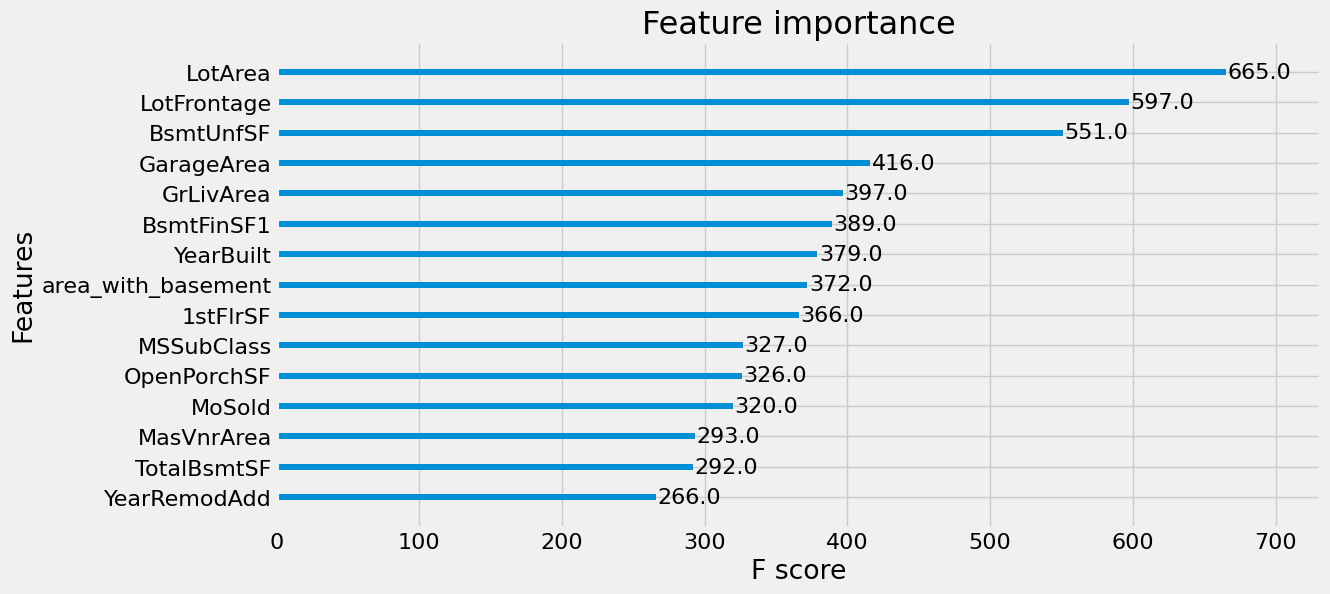

In [19]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(regressor, max_num_features=15, ax=ax)
plt.show();

Where here the `F score` is a measure "*...based on the number of times a variable is selected for splitting, weighted by the squared improvement to the model as a result of each split, and averaged over all trees*." [1] 

Note that these importances are susceptible to small changes in the training data, and it is much better to make use of ["GPU accelerated SHAP values"](https://www.kaggle.com/carlmcbrideellis/gpu-accelerated-shap-values-jane-street-example), incorporated with version 1.3 of XGBoost.

Can you follow the above guide use SHAP values instead of F Score?

In [20]:
#===========================================================================
# Using GPU accelerated SHAP values to analyze feature importance
#===========================================================================

n_trees = 500
dmat = xgb.DMatrix(X_train, y_train)

bst = xgb.train({"tree_method": "gpu_hist"}, dmat, n_trees)

bst.set_param({"predictor": "gpu_predictor"})

[21:14:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"



In [21]:
%%time 

# Compute the shap values
shap_values = bst.predict(dmat, pred_contribs=True)

[21:14:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

[21:14:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "predictor" } are not used.



CPU times: total: 750 ms
Wall time: 403 ms


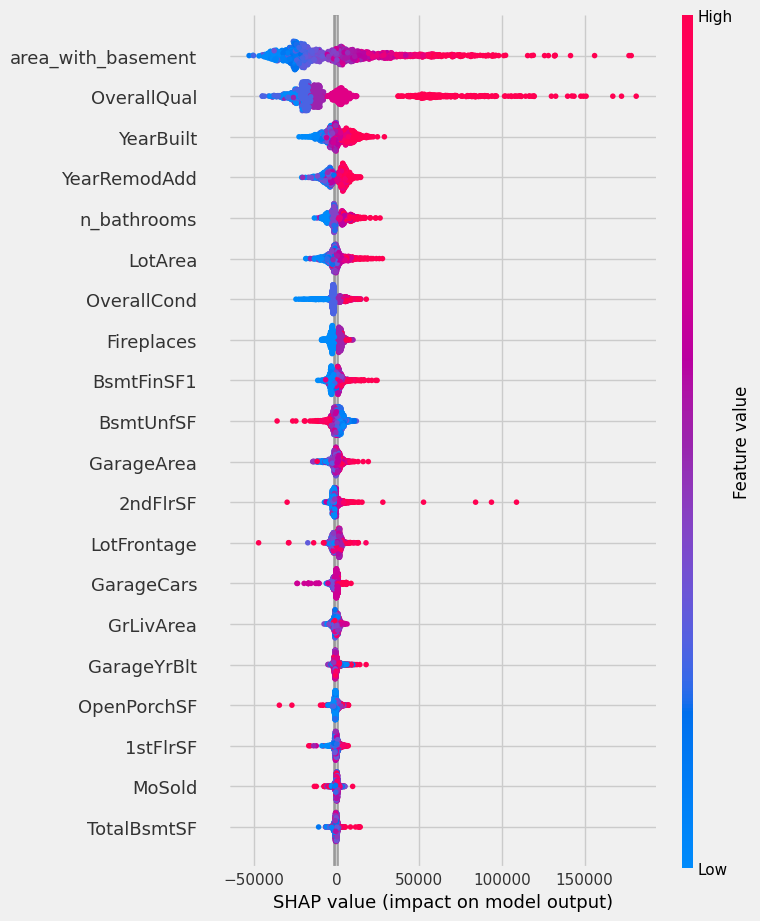

In [22]:
#===========================================================================
# Plotting feature importance obtained using GPU accelerated SHAP values
#===========================================================================

shap.summary_plot(shap_values[:,:-1], X_train)